# 1. Layers
### 1.1. Convolution Layer

In [31]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

def cls():
    tf.random.set_seed(42)
    tf.keras.backend.clear_session()

In [17]:
from sklearn.datasets import load_sample_images

images = load_sample_images()
images.keys()

dict_keys(['images', 'filenames', 'DESCR'])

In [18]:
images = images['images'] # It return 2 images
print("Original shape: ", images[0].shape)
images = tf.keras.layers.CenterCrop(70,120)(images)
images = tf.keras.layers.Rescaling(1/255)(images)
images.shape

Original shape:  (427, 640, 3)


TensorShape([2, 70, 120, 3])

In [20]:
cls()
cl = tf.keras.layers.Conv2D(filters=32, kernel_size=7) # 32*7*7*3
fmaps = cl(images)
fmaps.shape

TensorShape([2, 64, 114, 32])

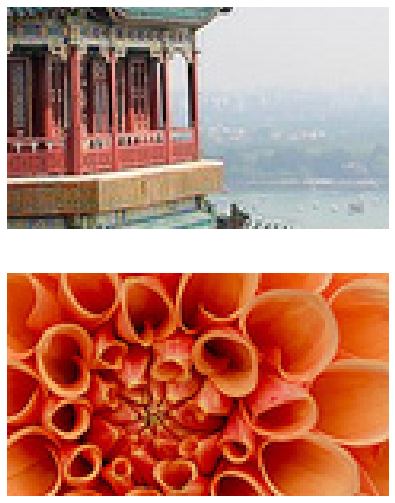

In [42]:
# Displaying original image
plt.figure(figsize=(15, 9))
for image_idx in range(images.shape[0]):
    plt.subplot(2,1,image_idx+1)
    plt.imshow(images[image_idx])
    plt.axis("off")

plt.show()

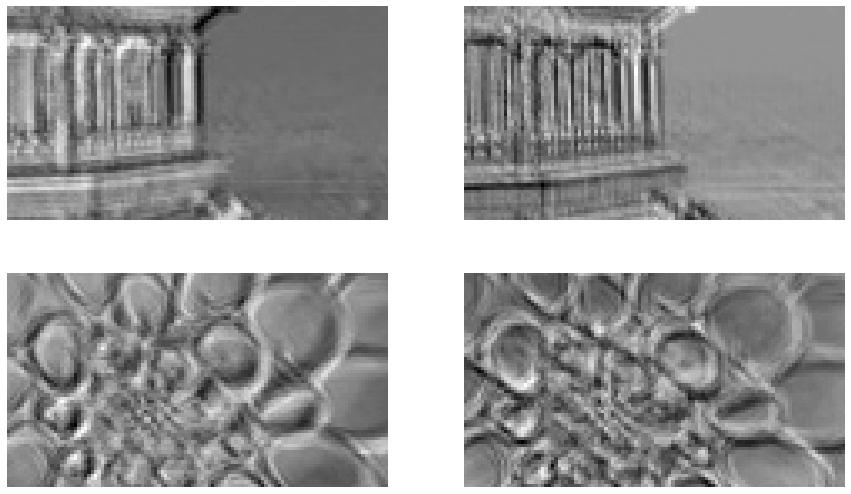

In [46]:
#displays the two output feature maps for each image
plt.figure(figsize=(15, 9))
for image_idx in range(fmaps.shape[0]):
    for fmap_idx in range(fmaps.shape[-1]-30): # only two filters showing
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

As we can see, randomly generated filters typically act like edge detectors, which is great since that's a useful tool in image processing, and that's the type of filters that a convolutional layer typically starts with. Then, during training, it gradually learns improved filters to recognize useful patterns for the task.

In [50]:
# Without zero padding
print("Image shape : ",images.shape)
fmaps = tf.keras.layers.Conv2D(32,7)(images)
fmaps.shape

Image shape :  (2, 70, 120, 3)


TensorShape([2, 64, 114, 32])

In [51]:
# Using zero padding
print("Image shape : ",images.shape)
fmaps = tf.keras.layers.Conv2D(32,7,padding='same')(images)
fmaps.shape

Image shape :  (2, 70, 120, 3)


TensorShape([2, 70, 120, 32])

In [55]:
# Using Stride=2  Image size will reduce
print("Image shape : ",images.shape)
fmaps = tf.keras.layers.Conv2D(32,7,padding='same',strides=2)(images)
fmaps.shape

Image shape :  (2, 70, 120, 3)


TensorShape([2, 35, 60, 32])

In [56]:
# this utility function can be useful to compute the size of the
# feature maps output by a convolutional layer. It also returns
# the number of ignored rows or columns if padding="valid", or the
#  number of zero-padded rows or columns if padding="same"
# Z = ((N + 2P - F)/S) + 1

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="same")


(array([35, 60], dtype=int32), array([5, 5]))

In [59]:
conv_layer = tf.keras.layers.Conv2D(32, 7, padding='same',strides=2)
fmaps = conv_layer(images)
kernels, biases = conv_layer.get_weights()
kernels.shape, biases.shape
# 7*7*3 represent as a single neuron we have 32 here + 32 bias terms

((7, 7, 3, 32), (32,))

In [63]:
#shows how to use the tf.nn.conv2d() operation
# This is low level API. we manually assign filter. If we want to 
cls()
filters = tf.random.normal([7, 7, 3, 2]) # 2 neurons 
biases = tf.zeros([2]) # two bias
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases
fmaps.shape

TensorShape([2, 70, 120, 2])

Let's manually create two filters full of zeros, except for a vertical line of 1s in the first filter, and a horizontal one in the second filter (just like in Figure 14–5). The two output feature maps highlight vertical lines and horizontal lines, respectively. In practice you will probably never need to create filters manually, since the convolutional layers will learn them automatically.

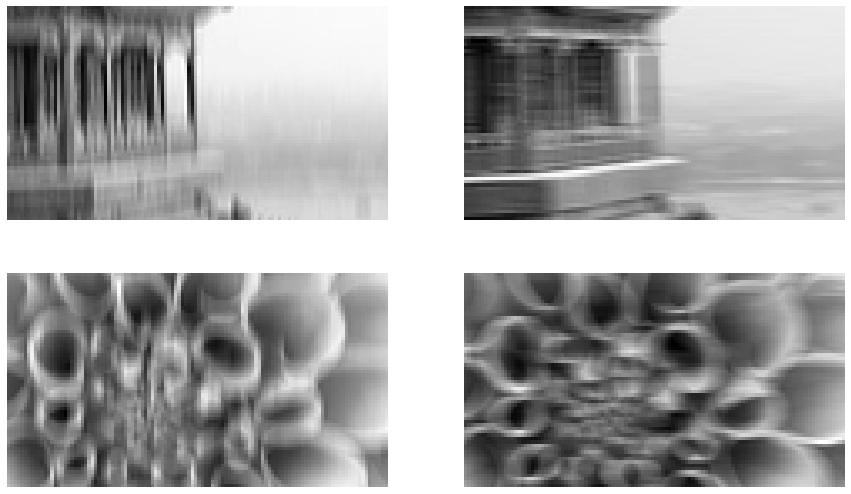

In [77]:
# With valid padding
cls()
plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1 # Vertical edge detector
filters[3, :, :, 1] = 1 # Horizontal edge detector
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="VALID")  + biases
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

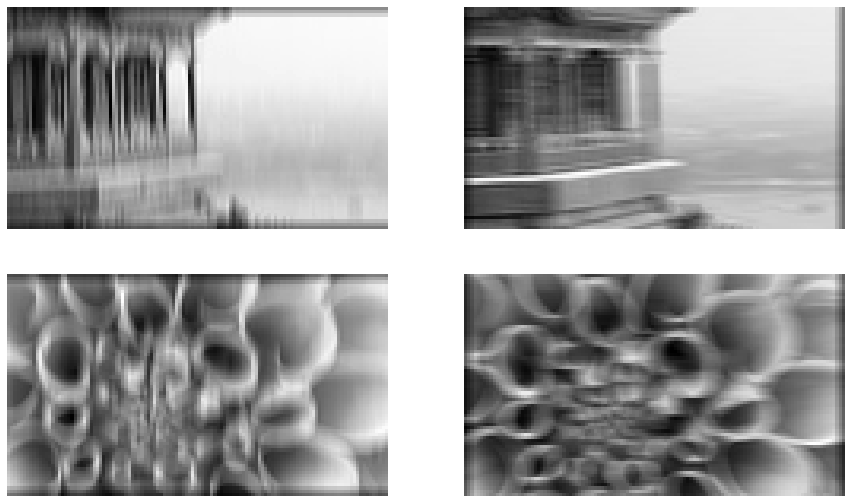

In [78]:
# With Same padding
cls()
plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1 # Vertical edge detector
filters[3, :, :, 1] = 1 # Horizontal edge detector
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME")  + biases

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

Notice the dark lines at the top and bottom of the two images on the left, and on the left and right of the two images on the right? Can you guess what these are? Why were they not present in the previous figure?

You guessed it! These are artifacts due to the fact that we used zero padding in this case, while we did not use zero padding to create the feature maps in the previous figure. Because of zero padding, the two feature maps based on the vertical line filter (i.e., the two left images) could not fully activate near the top and bottom of the images. Similarly, the two feature maps based on the horizontal line filter (i.e., the two right images) could not fully activate near the left and right of the images.

### 1.2. Pooling Layer

In [105]:
print("Img shape: ", images.shape)
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)# 2*2 matrix
output = max_pool(images)
output.shape

Img shape:  (2, 70, 120, 3)


TensorShape([2, 35, 60, 3])

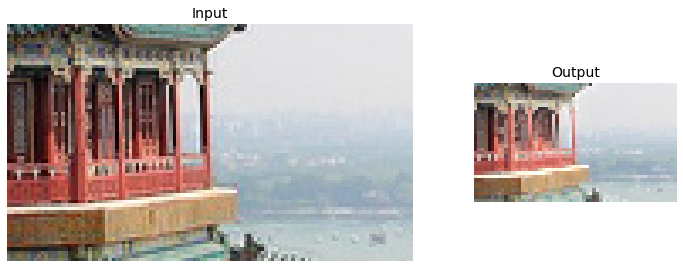

In [87]:
# what max pooling with stride = 2 looks like
import matplotlib as mpl
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

In [109]:
######################
# Depth-Wise Pooling #
######################
# Pooling layer took the pool over filters.
# shows how to use the max_pool() op; only works on the CPU
# If we want to take pool over combination of filters
# Like taking pool of group of filters then deepwise pooling use
#
np.random.seed(42)
fmaps = np.random.rand(2, 70, 120, 60)
with tf.device("/cpu:0"):
    output = tf.nn.max_pool(fmaps, 
                            ksize=(1, 1, 1, 3), 
                            strides=(1, 1, 1, 3),
                            padding="VALID")
output.shape

TensorShape([2, 70, 120, 20])

In [118]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
    
    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        groups = shape[-1] // self.pool_size  # number of channel groups
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        #tf.print(inputs, new_shape)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

In [119]:
np.allclose(DepthPool(pool_size=3)(fmaps), output)

True

In [120]:
DepthPool(pool_size=3)(fmaps)[0,0,0], output[0,0,0]

(<tf.Tensor: shape=(20,), dtype=float32, numpy=
 array([0.9507143 , 0.5986585 , 0.8661761 , 0.96990985, 0.83244264,
        0.52475643, 0.6118529 , 0.36636186, 0.785176  , 0.59241456,
        0.60754484, 0.965632  , 0.684233  , 0.4951769 , 0.9093204 ,
        0.66252226, 0.96958464, 0.93949896, 0.9218742 , 0.32533032],
       dtype=float32)>,
 <tf.Tensor: shape=(20,), dtype=float32, numpy=
 array([0.9507143 , 0.5986585 , 0.8661761 , 0.96990985, 0.83244264,
        0.52475643, 0.6118529 , 0.36636186, 0.785176  , 0.59241456,
        0.60754484, 0.965632  , 0.684233  , 0.4951769 , 0.9093204 ,
        0.66252226, 0.96958464, 0.93949896, 0.9218742 , 0.32533032],
       dtype=float32)>)

Shape:  (2, 70, 120, 1)


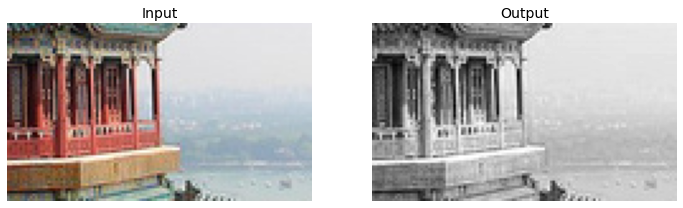

In [126]:
#computes and displays the output of the depthwise pooling layer

depth_output = DepthPool(pool_size=3)(images)
print("Shape: ", depth_output.shape)
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(images[0])  # plot the 1st image
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Output")
plt.imshow(depth_output[0, ..., 0], cmap="gray")  # plot 1st image's output
plt.axis("off")
plt.show()

In [128]:
##########################
# Global Average Pooling #
##########################
print(images.shape)
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()(images)
global_avg_pool.shape

(2, 70, 120, 3)


TensorShape([2, 3])

In [129]:
global_avg_pool

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.64338624, 0.5971759 , 0.5824972 ],
       [0.76306933, 0.26011038, 0.10849128]], dtype=float32)>

In [137]:
tf.reduce_mean(images[0,:,:,0]) # single channel average

<tf.Tensor: shape=(), dtype=float32, numpy=0.6433886>

In [140]:
# The above is equivalent to this
print(images.shape)
global_avg_pool = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=[1,2]))
global_avg_pool(images)


(2, 70, 120, 3)


<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.64338624, 0.5971759 , 0.5824972 ],
       [0.76306933, 0.26011038, 0.10849128]], dtype=float32)>

In [148]:
# MaxPool2D and MaxPooling2D Are same
print(images.shape)
global_avg_pool = tf.keras.layers.MaxPooling2D()
global_avg_pool(images).shape


(2, 70, 120, 3)


TensorShape([2, 35, 60, 3])

# 2. Top Architectures

In [2]:
# lets load the fashion mnist dataset
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
print(X_train_full.shape)
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
print(X_train_full.shape)
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

(60000, 28, 28)
(60000, 28, 28, 1)


### 2.1. Simple Structure

In [29]:
from functools import partial
cls()
DefaultConv2D = partial(tf.keras.layers.Conv2D, 
                        kernel_size=3, 
                        padding="same",
                        activation="relu", 
                        kernel_initializer="he_normal")
DefaultDense = partial(tf.keras.layers.Dense, 
                        activation='relu',
                        kernel_initializer="he_normal")
model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=12),
    DefaultConv2D(filters=12),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=24),
    DefaultConv2D(filters=24),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    DefaultDense(units=12),
    tf.keras.layers.Dropout(0.5),
    DefaultDense(units=12),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])
model.summary()                        

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 12)        6924      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 12)        1308      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 12)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 24)          2616      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 24)          5

In [5]:
model.compile(loss="sparse_categorical_crossentropy", 
            optimizer="nadam",
            metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=2,
                    validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test[:10])

Epoch 1/2
1719/1719 [==============================] - 73s 42ms/step - loss: 1.8171 - accuracy: 0.2963 - val_loss: 1.2192 - val_accuracy: 0.6916
Epoch 2/2
313/313 [==============================] - 4s 14ms/step - loss: 1.0585 - accuracy: 0.6883


In [31]:
# 7*7*1 will represent as a single neuron
# so their is total 64 neurons + 64 bias terms
weights, bias = model.get_layer("conv2d").weights
weights.shape, bias.shape

(TensorShape([7, 7, 1, 64]), TensorShape([64]))

In [46]:
print("Predicted classes : ",tf.argmax(y_pred, axis=1))
print("Actual classes    : ",y_test[:10])

Predicted classes :  tf.Tensor([9 2 1 1 6 1 2 2 5 7], shape=(10,), dtype=int64)
Actual classes    :  [9 2 1 1 6 1 4 6 5 7]


### 2.2. LeNet-5
Yan LeCun present this architecture back in 1999.
LeNet-5
The famous LeNet-5 architecture had the following layers:

Layer	Type	Maps	Size	Kernel size	Stride	Activation
Out	Fully connected	–	10	–	–	RBF
F6	Fully connected	–	84	–	–	tanh
C5	Convolution	120	1 × 1	5 × 5	1	tanh
S4	Avg pooling	16	5 × 5	2 × 2	2	tanh
C3	Convolution	16	10 × 10	5 × 5	1	tanh
S2	Avg pooling	6	14 × 14	2 × 2	2	tanh
C1	Convolution	6	28 × 28	5 × 5	1	tanh
In	Input	1	32 × 32	–	–	–


There were a few tweaks here and there, which don't really matter much anymore, but in case you are interested, here they are:

- MNIST images are 28 × 28 pixels, but they are zero-padded to 32 × 32 pixels and normalized before being fed to the network. The rest of the network does not use any padding, which is why the size keeps shrinking as the image progresses through the network.
- The average pooling layers are slightly more complex than usual: each neuron computes the mean of its inputs, then multiplies the result by a learnable coefficient (one per map) and adds a learnable bias term (again, one per map), then finally applies the activation function.
- Most neurons in C3 maps are connected to neurons in only three or four S2 maps (instead of all six S2 maps). See table 1 (page 8) in the original paper for details.
- The output layer is a bit special: instead of computing the matrix multiplication of the inputs and the weight vector, each neuron outputs the square of the Euclidian distance between its input vector and its weight vector. Each output measures how much the image belongs to a particular digit class. The cross-entropy cost function is now preferred, as it penalizes bad predictions much more, producing larger gradients and converging faster.

### 2.3. ResNet-34

In [47]:
from functools import partial

CustomConv2D = partial(tf.keras.layers.Conv2D,
                        kernel_size=3,
                        strides=1,
                        padding='same',
                        kernel_initializer="he_normal",
                        use_bias=False
                        )

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            CustomConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            CustomConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)                        

In [49]:
model = tf.keras.Sequential([
    CustomConv2D(64, kernel_size=7, strides=2, 
    input_shape=[224, 224, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
])
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation="softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)       

# 3. Transfer Learning
### 3.1. Using PreTrained model from Keras for prediction

In [51]:
# It will download weights of imagenet trained model
model = tf.keras.applications.ResNet50(weights='imagenet')

102981632/102967424 [==============================] - 238s 2us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________

In [52]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

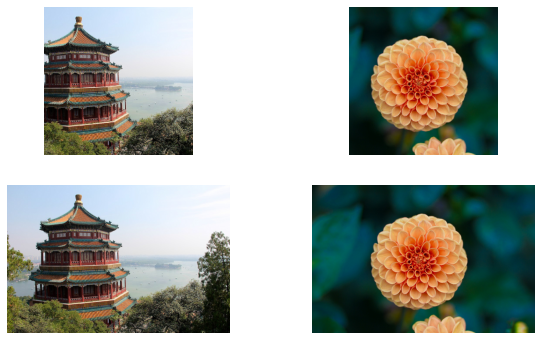

In [61]:
# Lets make the input in its required form
from sklearn.datasets import load_sample_images
images = load_sample_images()['images']
images_resized = tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True)(images)
plt.figure(figsize=(10, 6))
for id, idx in enumerate((0, 1,0,1)):
    plt.subplot(2, 2, id + 1)
    if id > 1:
        plt.imshow(images[idx] / 255)
    else:
        plt.imshow(images_resized[idx] / 255)
    plt.axis("off")

plt.show()

In [62]:
inputs  = tf.keras.applications.resnet50.preprocess_input(images_resized)
Y_proba = model.predict(inputs)
Y_proba.shape # Predict probability of 1000 classes for these 2 images

(2, 1000)

In [63]:
# Filtering top 3 classes that belongs to this image
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f"Image #{image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f"  {class_id} - {name:12s} {y_proba:.2%}")

49152/35363 [=========================================] - 0s 2us/step
Image #0
  n03877845 - palace       54.69%
  n03781244 - monastery    24.72%
  n02825657 - bell_cote    18.55%
Image #1
  n04522168 - vase         32.66%
  n11939491 - daisy        17.81%
  n03530642 - honeycomb    12.06%


### 3.2. Using PreTrained model for Transfer Learning

In [34]:
####################################################
# Lets load some data to retrain the Trained Model #
####################################################
import tensorflow as tf
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

Dl Completed...:   0%|          | 0/1 [00:00<?, ? url/s]

Dl Completed...: 100%|██████████| 1/1 [01:01<00:00, 61.77s/ url]


Dataset tf_flowers downloaded and prepared to ~\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [35]:
dataset_size

3670

In [36]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [37]:
n_classes

5

In [38]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

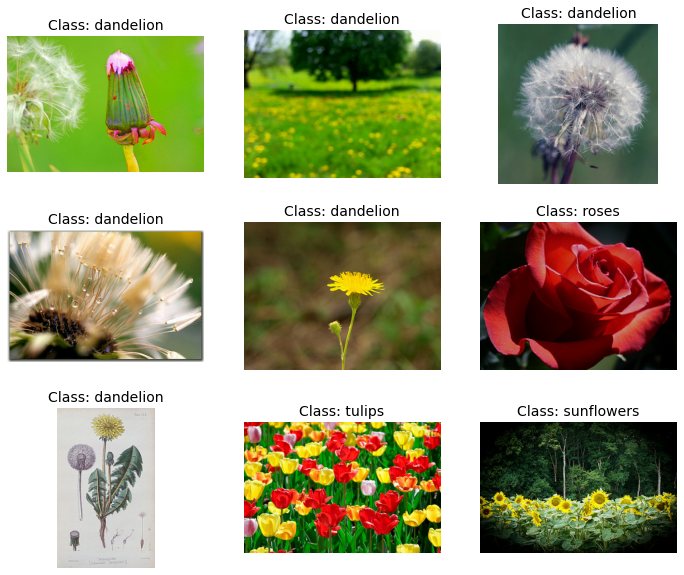

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
index = 0
for image, label in valid_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()

All three datasets contain individual images. We need to batch them, but for this we first need to ensure they all have the same size, or else batching will not work. We can use a Resizing layer for this. We must also call the tf.keras.applications.xception.preprocess_input() function to preprocess the images appropriately for the Xception model. We will also add shuffling and prefetching to the training dataset.

In [40]:
train_set_raw

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [43]:
cls()
batch_size = 32
# preprocess_input is the function not layer so we must use lambda layer
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=244, width=244, 
                            crop_to_aspect_ratio=False),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set  = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

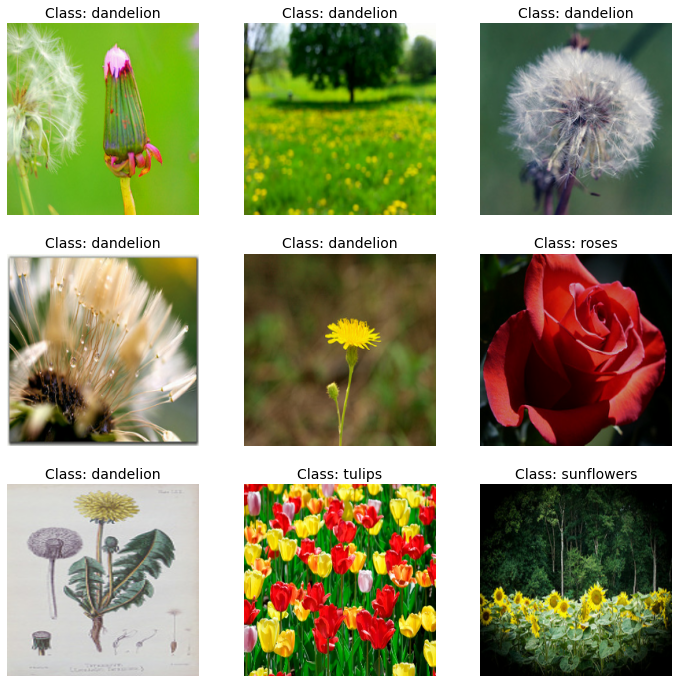

In [44]:
# Lets relook.
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [45]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

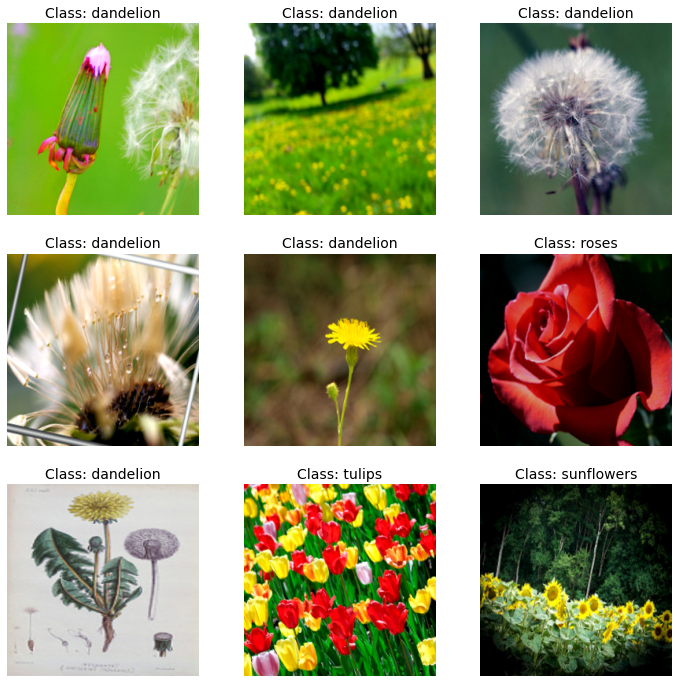

In [49]:
# displays the same first 9 images, after augmentation
# We can rerun this cell again and again to see different augmented image
import numpy as np

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds 
        # (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [ ]:
################################################################################
# Till now what we did:-
# Load the data
# Preprocessing
# - Resizing, input_preprocess, shuffle, batch_select, pre_fetch_single_batch  #
################################################################################

In [50]:
# Now let's load the pretrained model, without its top layers, 
# and replace them with our own, for the flower classification task
cls()
# include_top=False will remove the last layer
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
for layer in base_model.layers:
    layer.trainable = False
avg    = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
# Only this layers weight train
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model  = tf.keras.Model(inputs=base_model.input, outputs=output)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [51]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", 
                optimizer=optimizer,
                metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)


Epoch 1/3
12/86 [===>..........................] - ETA: 2:49 - loss: 0.8424 - accuracy: 0.6641

KeyboardInterrupt: 

In [52]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_1                33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [53]:
# If we want to improve performance of the model little
# bit more. we can do by retraining the top part of
# the base model. But with a lower learning rate
# as models loss function almost near at the global minima

In [64]:
"No. of layers: ",len(base_model.layers)

('No. of layers: ', 134)

In [63]:
for i in model.layers:
    if i.trainable:
        print(i, i.trainable)

<keras.layers.pooling.GlobalAveragePooling2D object at 0x00000223EDCFBD00> True
<keras.layers.core.Dense object at 0x000002238E7C2250> True


In [ ]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

# 4. Classification & Localization

In [67]:
cls()
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
for layers in base_model.layers:
    layers.trainable=False
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = tf.keras.layers.Dense(4)(avg)
model = tf.keras.Model(inputs=base_model.input,
                       outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2],  # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

In [68]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [106]:
# fits the model using random target bounding boxes (in real life
# you would need to create proper targets instead)

def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [127]:
#img = fake_train_set.take(1)

1

In [105]:
# It will take alot time so we do not train it.
model.fit(fake_train_set, epochs=2)

32

# 5. mAP relation with Precision/Recall

In [108]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

In [128]:
tf.random.uniform([32, 4]) # 4 bbox point of 32 batch image

<tf.Tensor: shape=(32, 4), dtype=float32, numpy=
array([[5.79192638e-01, 1.11850142e-01, 7.59304881e-01, 8.80769134e-01],
       [8.10689449e-01, 7.09245205e-01, 5.82820177e-01, 3.91045809e-02],
       [3.56138945e-01, 7.47609973e-01, 2.04818130e-01, 9.80080366e-02],
       [3.76530170e-01, 1.99291229e-01, 2.36241460e-01, 2.41368651e-01],
       [1.53284907e-01, 2.26304531e-02, 9.66133714e-01, 8.93608928e-01],
       [2.96295881e-02, 4.72728372e-01, 9.13342237e-01, 1.26104593e-01],
       [6.80452943e-01, 6.82448983e-01, 6.66493297e-01, 6.34932399e-01],
       [5.27840257e-01, 1.87031031e-02, 3.18150043e-01, 8.05832267e-01],
       [2.06281662e-01, 6.97817564e-01, 5.86316586e-01, 2.56450295e-01],
       [1.30254030e-02, 5.79955935e-01, 1.84415579e-02, 5.74068546e-01],
       [6.12744689e-01, 4.42052126e-01, 3.90383601e-01, 2.46371865e-01],
       [2.57117748e-01, 4.94626403e-01, 3.77462745e-01, 1.09561086e-01],
       [2.56205797e-01, 5.94456553e-01, 8.86354327e-01, 2.04126358e-01],
  

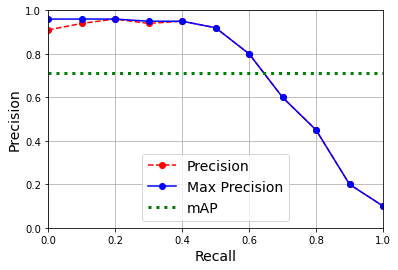

In [129]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center")
plt.show()